## Importing libraries & Reading files

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
from tqdm.notebook import tqdm
from pyxirr import xirr
print("Libraries Imported.")

# path of fundamental data file
f_path     = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Fundamental Data.csv"

# path of closing prices file 
c_path     = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Close Prices.csv"

# path of daily closing prices of Indexes : Nifty50 / NiftyMidcap100 / BSE500  as Sheetnames
index_path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\Indexes Daily Closing.xlsx"


#reading files
fdf = pd.read_csv(f_path, encoding='windows-1252')
cdf = pd.read_csv(c_path, encoding='windows-1252')

print("file reading done.")
#fdf.drop(columns=['Unnamed: 0'],inplace=True)
cdf.drop(columns=['Unnamed: 0'],inplace=True)
cdf.drop(columns=['Unnamed: 0.1'],inplace=True)

Libraries Imported.
file reading done.


# Input Variables
Enter your Input varibales here, in the given format

In [135]:

buy_date   = '2009-07-01'           # Format : YYYY-MM-DD
sell_date  = '2023-07-01'           # Format : YYYY-MM-DD
#churn_date = '2022-07-01'

indicator  = "ROCE"                 # Format : "ROCE" or "ROE"

m = 0                               # Top companies Ranking from m
n = 30                              # Top companies Ranking till n
                                    # Get top m to n companies;    here get Top 0-30 companies

transaction_cost = 0.1                # Percentage of Transaction cost eg.input 1 if you want 1% ; here 0.1 => 0.1%
capital = 1000000                   # Capital in the beginning of the backtest

weightage = "equal"                 # "equal" / "marketcap" / "rank" / "weighted_rank"
factor = 1.11



Ranking_Percentage_change = "High_to_Low"   # "High_to_Low" / "Low_to_High"


a = 500                             # Market Cap greater than equal to a =   500Cr   |   Put a = 0 if no Greater than condition
b = 20000                           # Market Cap smaller than equal to b = 20000Cr   |   Put b = np.inf if no Less than condition

positionsizing = "hold_stocks"      # Position Sizing methods
                                    # "sell_all_stocks"
                                    # "hold_stocks"
                                    # "30_Prev_year"   / "15_Prev_year" / "30_Next_year" / "15_Next_year"
                                    
                                    

### Getting data from inputs
No output for this code, just some minor calculations.

In [136]:
initial_capital   = capital

buy_date = pd.to_datetime(buy_date)
sell_date = pd.to_datetime(sell_date)

buy_str  = f"-{buy_date.month}-{buy_date.day}"
sell_str = f"-{sell_date.month}-{sell_date.day}"

start_year = buy_date.year - 1

# Getting End Year date

if buy_date.month > 3:
    end_year = sell_date.year - 2
else :
    end_year = sell_date.year - 3
    
    
    
if Ranking_Percentage_change == "Low_to_High":
    RPC = True
else :
    RPC = False
start_year, end_year

(2008, 2021)

----

## TRADE SHEET GENERATION CODE
Run this code to get the Trade Sheet
* **f1 :** *Reading Fundamental Data*
* **f2 :** *Store relevant columns of f1 after filters*
* **f3 :** *Top 30 (n) Stocks based on ROCE (indicator)*
* **f4 :** *Next Years Top 30 (n) Stocks to compare*
* **f5 :** *Previous Years Top 30 (n) Stocks to compare*
* **change :** *Adding every Year's Top 30 ROCE Stocks in this to get a complete list of all years*
* **TradeSheet :** *Final Tradesheet of all Years*

In [137]:
#------------------------------------------------  POSITION SIZING  -----------------------------------------------------
#                                                    CONDITION 1



if positionsizing == "sell_all_stocks":
    


    # Blank Dataframe to store Yearly Tradesheet
    change = pd.DataFrame()

    for year in tqdm(range(start_year, end_year+1)):

        f1 = fdf[fdf['Year']==year]

        # Fundamental Conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f1 = f1[f1.fillna(0)[condition] > 0]

        # Market Cap Condition
        f1 = f1[(f1['Market Cap']>=a) & (f1['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year

        # Indicator Conditions
        if indicator == "ROCE" :

            # Remove Banking stocks in ROCE
            f1 = f1[~f1['Name'].str.contains('Bank')]

            # ROCE Formula
            f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
            #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

        elif indicator == "ROE" :

            # ROE Formula
            f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100


        # New dataframe to store calculations 
        f2 = f1[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                                        # Buy Date

        # Dataframe of companies containing closings on 1st July of start year & next year
        cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
        cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']


        # Reset Indexes
        f2.reset_index(drop=True,inplace=True)
        cnam.reset_index(drop=True,inplace=True)


        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close1'},inplace=True)

        # SORTING VALUES BY INDICATOR
        f2 = f2.sort_values(by=[indicator], ascending=False)

        f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes

        # Adding Selling Date
        f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
        f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes

        # New Dataframe to store Top n Companies and Find Quantity
        f3 = f2[m:n]

        #display(f3)

        # Filling companies with no Selling Prices with last present close and update the Selling Dates
        for i in range(f3.shape[0]):
            if f3.fillna(0)['Close2'].iloc[i] == 0 :
                f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
                f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()

        #display(f3)

        # Claculating Quantity
        if weightage == "equal":
            f3['Qty'] = capital/((n-m)*f3['Close1'])
        elif weightage == "marketcap":
            f3['Qty'] = (capital * (f3['Market Cap']/f3['Market Cap'].sum())) / f3['Close1']
        elif weightage == "rank":
            new_weightage = f3.index[-1] - f3.index +1
            f3['Qty'] = (capital * (new_weightage/sum(f3.index))) / f3['Close1']



        # Defining a function to Roundown Quantity
        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)




        # Rounddown Quantity
        f3['Qty'] = f3['Qty'].apply(Floor)
        
        
        # Qty Holding will be used to store the Quantity that we are holding since it was bought.
        f3['Qty Holding'] = f3['Qty']
        
        # Holding Amt will be used to store the Amount of Stock that we are holding since it was bought.
        f3['Holding Amt'] = f3['Qty']*f3['Close1']
        
        
        # Buying & Selling Value = Qty x Close Price
        f3['Buy Value'] = f3['Qty']*f3['Close1']
        f3['Sell Value'] = f3['Qty']*f3['Close2']

        f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100

        f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])

        #print(f"{year} Starting Capital is {capital}")

        capital = f3['Sell Value'].sum() - f3['Transaction Cost'].sum()

        # print(f"{year} Ending Capital is {capital}")
        # print(year," Shape : ",f3.shape[0])
        change = pd.concat((change,f3),axis=0)
        #change = change.append(f3)

    
    
    # Displaying our Trade Sheet
    display(change)
    
    # CAGR
    
    cagr = xirr([ str(date(start_year+1,buy_date.month,buy_date.day)) , str(buy_date) ],[-initial_capital,capital]) * 100

    #agr        = ((capital/initial_capital)**(1/(buy_date.year-start_year))-1)*100
    print(cagr)
    
    
    
    # Unique path according to the input variables to store the Trade File, same will be used to store the Trade Reports later.
    path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\P1-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-Reports.xlsx"
    
    #exporting the Trade Sheet
    change.to_excel(path_to,sheet_name="Trade Report Sheet")
    
    
    


    

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#------------------------------------------------  POSITION SIZING  -----------------------------------------------------
#                                                    CONDITION 2  





elif positionsizing == "hold_stocks":
    


    # Blank Dataframe to store Yearly Tradesheet
    change = pd.DataFrame()
    f5 = pd.DataFrame()

    for year in tqdm(range(start_year, end_year+1)):

        #print(f"{int(capital)} : Starting Capital for {year} ")
        
        f1 = fdf[fdf['Year']==year]

        # Fundamental Conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f1 = f1[f1.fillna(0)[condition] > 0]

        # Market Cap Condition
        f1 = f1[(f1.fillna(0)['Market Cap']>=a) & (f1.fillna(0)['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year

        # Indicator Conditions
        if indicator == "ROCE" :

            # Remove Banking stocks in ROCE
            f1 = f1[~f1['Name'].str.contains('Bank')]

            # ROCE Formula
            f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
            #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

        elif indicator == "ROE" :

            # ROE Formula
            f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100


        # New dataframe to store calculations 
        f2 = f1[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                           # Buy Date



        # Dataframe of companies containing closings on 1st July of start year & next year
        cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
        cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']


        # Reset Indexes
        f2.reset_index(drop=True,inplace=True)
        cnam.reset_index(drop=True,inplace=True)


        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close1'},inplace=True)

        f2['Sell Date' ] = date(year+2,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
        f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes




        # SORTING VALUES BY INDICATOR
        f2 = f2.sort_values(by=[indicator], ascending=False)

        f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes

        # New Dataframe to store Top n Companies and Find Quantity
        f3 = f2[m:n]

        #display(f3)


        # Filling companies with no Selling Prices with last present close and update the Selling Dates
        for i in range(f3.shape[0]):
            if f3.fillna(0)['Close2'].iloc[i] == 0 :
                f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
                f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()





        # Defining a function for Roundown
        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)



        # Calculations for first year
        if year == start_year:

            f3['Prev Year'] = 0

            # Claculating Quantity
            if weightage == "equal":
                f3['Qty'] = capital/((f3.shape[0])*f3['Close1'])
            elif weightage == "marketcap":
                f3['Qty'] = (capital * (f3['Market Cap']/f3['Market Cap'].sum())) / f3['Close1']
            elif weightage == "rank":
                #new_weightage = f3.index[-1] - f3.index +1
                f3['Qty'] = f3.index
                f3['Qty'] = f3.index[-1] - f3['Qty'] +1
                f3['Qty'] = (capital * (f3['Qty']/sum(f3.index))) / f3['Close1']
                
            elif weightage == "weighted_rank":
            
                f3['Qty'] = f3.index
                f3['Qty'] = f3.shape[0] - f3['Qty']
                f3['Qty'] = factor ** f3['Qty']
                #f3['Qty'] = f3['Qty'] ** factor

                f3['Qty'] = f3['Qty']/f3['Qty'].sum()
                f3['Qty'] = (capital * f3['Qty']) / f3['Close1']
                
                
                

            f3['Qty Holding'] = f3['Qty']    



        # Calculations for next years
        else:

            # Creating a column to store if the company is present in previous year.
            f3['Prev Year'] = f3['Name'].isin(f5['Name']).astype(int)

            n_prev = f3[f3['Prev Year'] == 0]                                          #Stocks not present in previous years
            y_prev = f3[f3['Prev Year'] == 1]                                          #Stocks present in previous years
            
            n_prev.reset_index(drop=True,inplace=True)
            y_prev.reset_index(drop=True,inplace=True)
            
            # Claculating Quantity for companies not present in previous year
            if weightage == "equal":
                n_prev['Qty'] = capital/((n_prev.shape[0])*n_prev['Close1'])
            
            elif weightage == "marketcap":
                n_prev['Qty'] = (capital * (n_prev['Market Cap']/n_prev['Market Cap'].sum())) / n_prev['Close1']
            
            elif weightage == "rank":

                n_prev['Qty'] = n_prev.index
                n_prev['Qty'] = n_prev.index[-1] - n_prev['Qty'] +1
                n_prev['Qty'] = (capital * (n_prev['Qty']/sum(n_prev.index))) / n_prev['Close1']
            
            
            elif weightage == "weighted_rank":
            
                n_prev['Qty'] = n_prev.index
                n_prev['Qty'] = n_prev.shape[0] - n_prev['Qty']
                n_prev['Qty'] = factor ** n_prev['Qty']
                #n_prev['Qty'] = n_prev['Qty'] ** factor

                n_prev['Qty'] = n_prev['Qty']/n_prev['Qty'].sum()
                n_prev['Qty'] = (capital * n_prev['Qty']) / n_prev['Close1']
                
                
                
            

            n_prev['Qty Holding'] = n_prev['Qty']

            # Claculating Quantity for companies present in previous year
            y_prev[['Buy Date','Qty','Qty Holding']] = np.nan

            for k in range(y_prev.shape[0]):
                y_prev['Qty Holding'].iloc[k] = f5[f5['Name'] == y_prev['Name'].iloc[k]]['Qty Holding'].iloc[0]

            # Merging above 2 dataframes back to f3
            f3 = pd.concat((y_prev,n_prev),axis=0)
            #f3 = y_prev.append(n_prev)
            
            f3.sort_values(by=[indicator],ascending=False, inplace=True)
        
        f3.reset_index(drop=True,inplace=True)
        
        f3['Qty'] = f3['Qty'].apply(Floor)
        f3['Qty Holding'] = f3['Qty Holding'].apply(Floor)
        f3['Buy Value'] = f3['Qty']*f3['Close1']








        #----------------------------------------------NEXT YEAR COMPANIES--------------------------------------------------


        # Finding Next years Companies to compare

        f4 = fdf[fdf['Year']==(year+1)]

        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f4 = f4[f4.fillna(0)[condition] > 0]

        f4 = f4[(f4.fillna(0)['Market Cap']>=a) & (f4.fillna(0)['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year


        if indicator == "ROCE" :
            f4 = f4[~f4['Name'].str.contains('Bank')]
            f4[indicator] = (f4['Adj PBIT'].fillna(0) / (f4["Shareholder's Funds"].fillna(0) + f4["Total Debt"].fillna(0)))*100
        elif indicator == "ROE" :
            f4[indicator] = (f4['Adj PAT'].fillna(0) / f4["Shareholder's Funds"].fillna(0))*100

        f4 = f4[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f4['Buy Date'] = date(year+2,buy_date.month,buy_date.day)                                           # Buy Date

        # Dataframe of companies containing closings on 1st July of start year & next year
        cnam3  = cdf[cdf['Date'] == f'{year+2}{buy_str}']
        cnam4  = cdf[cdf['Date'] == f'{year+3}{sell_str}']

        # Reset Indexes
        f4.reset_index(drop=True,inplace=True)
        cnam3.reset_index(drop=True,inplace=True)

        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f4 = pd.merge(f4,cnam3[['Name','Close']], how='left',on='Name').dropna()
        f4.rename(columns={'Close':'Close1'},inplace=True)

        f4['Sell Date' ] = date(year+3,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f4 = pd.merge(f4,cnam4[['Name','Close']], how='left',on='Name')
        f4.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes

        # SORTING VALUES BY INDICATOR
        f4 = f4.sort_values(by=[indicator], ascending=False)

        f4.reset_index(drop=True,inplace=True)                                                 # Reset Indexes

        # New Dataframe to store Top n Companies and Find Quantity
        f4 = f4[m:n]
        
    #------------------------------------------------------------------------------------------------------------------------
    



        # Creating a column to store if the company is present in next year.
        f3['Next Year'] = f3['Name'].isin(f4['Name'].tolist()).astype(int)
        n_next = f3[f3['Next Year']==0]
        y_next = f3[f3['Next Year']==1]

        # Calculating Sell Value and Sell Date differently for above 2 dataframes
        n_next['Sell Value'] = n_next['Qty Holding']*n_next['Close2']
        y_next[['Sell Date','Sell Value']] = np.nan

        
        f3 = pd.concat((y_next,n_next),axis=0)
        #f3 = y_next.append(n_next)
        
        f3.sort_values(by=[indicator],ascending=False, inplace=True)


        f3['Transaction Cost'] = (transaction_cost / 100)*(f3.fillna(0)['Buy Value']+f3.fillna(0)['Sell Value'])

        f3['% Change'] = (f3['Close2']/f3['Close1']-1)*100 

        f5 = f3.copy()

        portfolio_value = (capital - f3.fillna(0)['Buy Value'].sum()) + ((f3['Qty Holding']*f3['Close2']) - f3['Transaction Cost']).sum()
        
        y_returns = (((capital - f3.fillna(0)['Buy Value'].sum()) + f3.fillna(0)['Sell Value'].sum() - f3['Transaction Cost'].sum())/capital - 1)*100

        # Changing Capital for next year to Ending capital of this year 
        capital = (capital - f3.fillna(0)['Buy Value'].sum()) + f3.fillna(0)['Sell Value'].sum() - f3['Transaction Cost'].sum()
        #print(int(capital),": Ending Capital")


        # Appending every year's Trade file to a Dataframe "change"
        change = pd.concat((change,f3),axis=0)
        #change = change.append(f3)
        
    

    #------------------------------------------GETTING TRADESHEET FROM ABOVE DATAFRAME-----------------------------------------




    change2 = change.copy()
    s = pd.DataFrame(columns=change2.columns)
    change2.reset_index(drop=True, inplace=True)
    comp_list = []

    for i in range(change2.shape[0]):
        if change2['Name'].iloc[i] not in comp_list:

            t = change2[change2['Name']==change2['Name'].iloc[i]]
            t = t[(t.fillna(0)['Buy Date']!=0) | (t.fillna(0)['Sell Date']!=0)]
            
            comp_list.append(change2['Name'].iloc[i])

            for g in range(t.shape[0]):

                if t.fillna(0)['Buy Date'].iloc[g] !=0 and t.fillna(0)['Sell Date'].iloc[g] !=0 :
                    s = pd.concat((s,t[g:g+1]),axis=0)
                    #s = s.append(t.iloc[g])
                elif t.fillna(0)['Buy Date'].iloc[g] ==0 and t.fillna(0)['Sell Date'].iloc[g] ==0 :
                    continue
                elif t.fillna(0)['Buy Date'].iloc[g] !=0 and t.fillna(0)['Sell Date'].iloc[g] ==0 :
                    s = pd.concat((s,t[g:g+1]),axis=0)
                    #s = s.append(t.iloc[g])

                elif t.fillna(0)['Buy Date'].iloc[g] ==0 and t.fillna(0)['Sell Date'].iloc[g] !=0:

                    s['Sell Date'].iloc[-1]  = t['Sell Date'].iloc[g]
                    s['Close2'].iloc[-1]     = t['Close2'].iloc[g]
                    s['Sell Value'].iloc[-1] = t['Sell Value'].iloc[g]
        else:
            continue

        
        
        
    
    s['% Change'] = (s['Close2']/s['Close1']-1)*100      

    s = s.sort_values(by=['Buy Date','ROCE'], ascending=[True,False])
    

    TradeSheet = s[['Name','Market Cap','ROCE','Buy Date','Close1','Sell Date','Close2','Qty','Buy Value','Sell Value','Qty Holding','% Change','Transaction Cost']]
    TradeSheet.reset_index(drop=True,inplace=True)    
    
    
    cagr = xirr([ str(buy_date) , str(sell_date) ],[-initial_capital,portfolio_value]) * 100
    
    #cagr        = ((portfolio_value/initial_capital)**(1/(buy_date.year-start_year))-1)*100


    #display(change)
    display(TradeSheet)
    print(cagr)
    
    
    
    # Unique path according to the input variables to store the Trade File, same will be used to store the Trade Reports later.
    #path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\P2-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-Reports.xlsx"

    
    # Exporting files
    change.to_excel(path_to,sheet_name="Trade Report Sheet")
    
    #cagr_df.to_excel(r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\Yearly_Change.xlsx")
    
    #TradeSheet.to_excel(fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\P2-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-TradeSheet.xlsx")
    

    
    
    
    


#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#------------------------------------------------  POSITION SIZING  -----------------------------------------------------
#                                                    CONDITION 3      
    
    


    
elif positionsizing == "30_Prev_year" or "15_Prev_year":
    
    portfolio_dict = {}
    portfolio_dict[date(start_year+1,buy_date.month,buy_date.day)] = capital

    # Blank Dataframe to store Yearly Tradesheet
    change = pd.DataFrame()

    for year in tqdm(range(start_year, end_year+1)):

        f1 = fdf[fdf['Year']==year]

        # Fundamental Conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f1 = f1[f1.fillna(0)[condition] > 0]

        # Market Cap Condition
        f1 = f1[(f1['Market Cap']>=a) & (f1['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year

        # Indicator Conditions
        if indicator == "ROCE" :

            # Remove Banking stocks in ROCE
            f1 = f1[~f1['Name'].str.contains('Bank')]

            # ROCE Formula
            f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
            #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

        elif indicator == "ROE" :

            # ROE Formula
            f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100


        # New dataframe to store calculations 
        f2 = f1[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                           # Buy Date

        # Dataframe of companies containing closings on 1st July of start year, next year & prev year.
        cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
        cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']
        cnam3 = cdf[cdf['Date'] == f'{year}{buy_str}']

        # Reset Indexes
        f2.reset_index(drop=True,inplace=True)
        cnam.reset_index(drop=True,inplace=True)


        
        
        
        
        
        # Adding Closing Prices of Prev year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam3[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close0'},inplace=True)

        # SORTING VALUES BY INDICATOR
        #f2 = f2.sort_values(by=[indicator], ascending=False)

        f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes
        
        
        

        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close1'},inplace=True)
        
        f2.reset_index(drop=True,inplace=True)
        
        f2['Prev Yr %'] = (f2['Close1']/f2['Close0'] - 1)*100
        
        
        
        # Adding Selling Date
        f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
        f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes

        
        
        
        # SORTING VALUES BY INDICATOR
        f2 = f2.sort_values(by=[indicator], ascending=False)
        
        
        
        
        
        # New Dataframe to store combinations of Companies and Find Quantity
        f3 = f2[m:n]
        f3 = f3.sort_values(by=['Prev Yr %'], ascending=RPC)
        
        f3.reset_index(drop=True,inplace=True)
        
        if positionsizing == "15_Prev_year":
            f3 = f3[:15]
        elif positionsizing == "30_Prev_year":
            f3 = f3
        
        
        
        
        
        f3.reset_index(drop=True,inplace=True)
        
        #display(f3)

        # Filling companies with no Selling Prices with last present close and update the Selling Dates
        for i in range(f3.shape[0]):
            if f3.fillna(0)['Close2'].iloc[i] == 0 :
                f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
                f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()

        #display(f3)

        # Claculating Quantity
        if weightage == "equal":
            f3['Qty'] = capital/((f3.shape[0])*f3['Close1'])
        
        elif weightage == "marketcap":
            f3['Qty'] = (capital * (f3['Market Cap']/f3['Market Cap'].sum())) / f3['Close1']
            
        elif weightage == "rank":
            
            f3['Qty'] = f3.index
            f3['Qty'] = f3.index[-1] - f3['Qty'] +1
            f3['Qty'] = (capital * (f3['Qty']/sum(f3['Qty']))) / f3['Close1']
        elif weightage == "weighted_rank":
            
            f3['Qty'] = f3.index
            f3['Qty'] = f3.shape[0] - f3['Qty']
            f3['Qty'] = factor ** f3['Qty']
            #f3['Qty'] = f3['Qty'] ** factor
            
            f3['Qty'] = f3['Qty']/f3['Qty'].sum()
            f3['Qty'] = (capital * f3['Qty']) / f3['Close1']



        # Defining a function to Roundown Quantity
        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)




        # Rounddown Quantity
        f3['Qty'] = f3['Qty'].apply(Floor)
        
        
        # Qty Holding will be used to store the Quantity that we are holding since it was bought.
        f3['Qty Holding'] = f3['Qty']
        
        # Holding Amt will be used to store the Amount of Stock that we are holding since it was bought.
        f3['Holding Amt'] = f3['Qty']*f3['Close1']
        
        
        # Buying & Selling Value = Qty x Close Price
        f3['Buy Value'] = f3['Qty']*f3['Close1']
        f3['Sell Value'] = f3['Qty']*f3['Close2']

        f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100

        f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])

        #print(f"{year} Starting Capital is {capital}")
        
        
        capital = (capital - f3.fillna(0)['Buy Value'].sum()) + f3.fillna(0)['Sell Value'].sum() - f3['Transaction Cost'].sum()
        
        portfolio_dict[date(year+2,buy_date.month,buy_date.day)] = capital
        # print(f"{year} Ending Capital is {capital}")

        
        
        change = pd.concat((change,f3),axis=0)
        #change = change.append(f3)
        
        
    
    
    # Displaying our Trade Sheet
#    display(change)
    
    # CAGR
    portfolio_df = pd.DataFrame(portfolio_dict.items())
    portfolio_df.columns = ['Date','PV']
    cagr = xirr([ str(date(start_year+1,buy_date.month,buy_date.day)) , str(buy_date) ],[-initial_capital,capital]) * 100

    #agr        = ((capital/initial_capital)**(1/(buy_date.year-start_year))-1)*100
    print(cagr)
    
    
    
    # Unique path according to the input variables to store the Trade File, same will be used to store the Trade Reports later.
    #path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\New Model 2.3 Outputs\P3-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-Reports.xlsx"
    path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\New Model 2.3 Outputs\15 Stocks {Ranking_Percentage_change} {weightage}.xlsx"
    
    
    
    #exporting the Trade Sheet
    change.to_excel(path_to,sheet_name="Trade Report Sheet")
    
    
    with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
        portfolio_df.to_excel(writer,sheet_name="Portfolio Value Yearly",index=False)


    

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#------------------------------------------------  POSITION SIZING  -----------------------------------------------------
#                                                    CONDITION 4  





elif positionsizing == "30_Next_year" or "15_Next_year":
    print("Next year entered")
    portfolio_dict = {}
    portfolio_dict[date(start_year+1,buy_date.month,buy_date.day)] = capital

    # Blank Dataframe to store Yearly Tradesheet
    change = pd.DataFrame()

    for year in tqdm(range(start_year, end_year+1)):

        f1 = fdf[fdf['Year']==year]

        # Fundamental Conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f1 = f1[f1.fillna(0)[condition] > 0]

        # Market Cap Condition
        f1 = f1[(f1['Market Cap']>=a) & (f1['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year

        # Indicator Conditions
        if indicator == "ROCE" :

            # Remove Banking stocks in ROCE
            f1 = f1[~f1['Name'].str.contains('Bank')]

            # ROCE Formula
            f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
            #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

        elif indicator == "ROE" :

            # ROE Formula
            f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100


        # New dataframe to store calculations 
        f2 = f1[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                           # Buy Date

        # Dataframe of companies containing closings on 1st July of start year, next year & prev year.
        cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
        cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']
        cnam3 = cdf[cdf['Date'] == f'{year}{buy_str}']

        # Reset Indexes
        f2.reset_index(drop=True,inplace=True)
        cnam.reset_index(drop=True,inplace=True)


        
        
        
        
        
        # Adding Closing Prices of Prev year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam3[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close0'},inplace=True)

        # SORTING VALUES BY INDICATOR
        #f2 = f2.sort_values(by=[indicator], ascending=False)

        f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes
        
        
        

        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close1'},inplace=True)
        
        f2.reset_index(drop=True,inplace=True)
        
        
        
        
        # Adding Selling Date
        f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
        f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes

        
        
        
        
        
        # SORTING VALUES BY INDICATOR
        f2 = f2.sort_values(by=[indicator], ascending=False)
        
        
        
        
        
        # New Dataframe to store combinations of Companies and Find Quantity
        f3 = f2[m:n]
        f3.reset_index(drop=True,inplace=True)
        
        
        
        
        
        
        
        display(f3)

        # Filling companies with no Selling Prices with last present close and update the Selling Dates
        for i in range(f3.shape[0]):
            if f3.fillna(0)['Close2'].iloc[i] == 0 :
                f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
                f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()
        
        #display(f3)
        
        
        
        
        
        f3['Next Yr %'] = (f3['Close2']/f3['Close1'] - 1)*100
        f3 = f3.sort_values(by=['Next Yr %'], ascending=RPC)
        
        f3.reset_index(drop=True,inplace=True)
        
        if positionsizing == "15_Next_year":
            f3 = f3[:15]
        elif positionsizing == "30_Next_year":
            f3 = f3
        
        f3.reset_index(drop=True,inplace=True)
        
        display(f3)
        
        
        
        
        
        # Claculating Quantity
        if weightage == "equal":
            f3['Qty'] = capital/((f3.shape[0])*f3['Close1'])
        
        elif weightage == "marketcap":
            f3['Qty'] = (capital * (f3['Market Cap']/f3['Market Cap'].sum())) / f3['Close1']
            
        elif weightage == "rank":
            
            f3['Qty'] = f3.index
            f3['Qty'] = f3.index[-1] - f3['Qty'] +1
            f3['Qty'] = (capital * (f3['Qty']/sum(f3['Qty']))) / f3['Close1']
            
        elif weightage == "weighted_rank":
            
            f3['Qty'] = f3.index
            f3['Qty'] = f3.shape[0] - f3['Qty']
            f3['Qty'] = factor ** f3['Qty']
            #f3['Qty'] = f3['Qty'] ** factor
            
            f3['Qty'] = f3['Qty']/f3['Qty'].sum()
            f3['Qty'] = (capital * f3['Qty']) / f3['Close1']



        # Defining a function to Roundown Quantity
        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)




        # Rounddown Quantity
        f3['Qty'] = f3['Qty'].apply(Floor)
        
        
        # Qty Holding will be used to store the Quantity that we are holding since it was bought.
        f3['Qty Holding'] = f3['Qty']
        
        # Holding Amt will be used to store the Amount of Stock that we are holding since it was bought.
        f3['Holding Amt'] = f3['Qty']*f3['Close1']
        
        
        # Buying & Selling Value = Qty x Close Price
        f3['Buy Value'] = f3['Qty']*f3['Close1']
        f3['Sell Value'] = f3['Qty']*f3['Close2']

        f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100

        f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])

        #print(f"{year} Starting Capital is {capital}")
        
        
        capital = (capital - f3.fillna(0)['Buy Value'].sum()) + f3.fillna(0)['Sell Value'].sum() - f3['Transaction Cost'].sum()
        
        portfolio_dict[date(year+2,buy_date.month,buy_date.day)] = capital
        # print(f"{year} Ending Capital is {capital}")

        
        
        change = pd.concat((change,f3),axis=0)
        #change = change.append(f3)
        
        
    
    
    # Displaying our Trade Sheet
#    display(change)
    
    # CAGR
    portfolio_df = pd.DataFrame(portfolio_dict.items())
    portfolio_df.columns = ['Date','PV']
    cagr = xirr([ str(buy_date) , str(sell_date) ],[-initial_capital,capital]) * 100

    #cagr        = ((capital/initial_capital)**(1/(buy_date.year-start_year))-1)*100
    print(cagr)
    
    
    
    # Unique path according to the input variables to store the Trade File, same will be used to store the Trade Reports later.
    #path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\New Model 2.3 Outputs\P3-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-Reports.xlsx"
    path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\New Model 2.3 Outputs\{n} Stocks {Ranking_Percentage_change} {weightage}.xlsx"
    
    
    
    #exporting the Trade Sheet
    change.to_excel(path_to,sheet_name="Trade Report Sheet")
    
    
     with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
         portfolio_df.to_excel(writer,sheet_name="Portfolio Value Yearly",index=False)

  0%|          | 0/14 [00:00<?, ?it/s]

14.527981778092514


----------

## REPORTS GENERATION CODE
Run this code to get the Trade Reports  
  
**You'll get the following as outputs:**
* Top Winners
* Top Losers
* Daily Portfolio Value from start date to end
* Portfolio Graph
* Drawdown Graph
* CAGR, Trading Edge, MDD & CAR/MDD


TOP WINNERS


,Name,Buy Date,% Change
0,Alkyl Amines Chemicals Ltd.,2020-07-01,327.409117
1,Deepak Nitrite Ltd.,2020-07-01,293.180157
2,Tanfac Industries Ltd.,2022-07-01,241.671931
3,TTK Prestige Ltd.,2010-07-01,240.379754
4,Symphony Ltd.,NaN,231.245006
5,Indiamart Intermesh Ltd.,2020-07-01,223.082839
6,Sonata Software Ltd.,NaN,216.624738
7,LS Industries Ltd.,2012-07-01,202.103250
8,Avanti Feeds Ltd.,NaN,188.634829
9,Ajanta Pharma Ltd.,2013-07-01,174.205951



TOP LOSERS


,Name,Buy Date,% Change
0,Capri Global Capital Ltd.,2010-07-01,-88.857609
1,Spectacle Ventures Ltd.,2010-07-01,-87.167806
2,Securekloud Technologies Ltd.,NaN,-82.825089
3,Stampede Capital Ltd.,2016-07-01,-80.411499
4,Suumaya Industries Ltd.,2021-07-01,-78.824268
5,EKI Energy Services Ltd.,2022-07-01,-75.896348
6,Vakrangee Ltd.,2017-07-01,-68.964717
7,Paul Merchants Ltd.,2018-07-01,-65.376787
8,NBCC (India) Ltd.,2019-07-01,-61.258278
9,Graphite India Ltd.,2018-07-01,-60.290442



Daily Portfolio Value


,Date,PV,MDD
0,2023-06-30,6.684090e+06,-0.1706
1,2023-06-29,6.684090e+06,-0.1706
2,2023-06-28,6.684090e+06,-0.1706
3,2023-06-27,6.684090e+06,-0.1706
4,2023-06-26,6.684090e+06,-0.1706
...,...,...,...
5108,2009-07-05,9.938232e+05,0.0000
5109,2009-07-04,9.938232e+05,0.0000
5110,2009-07-03,9.938232e+05,0.0000
5111,2009-07-02,9.935287e+05,0.0000


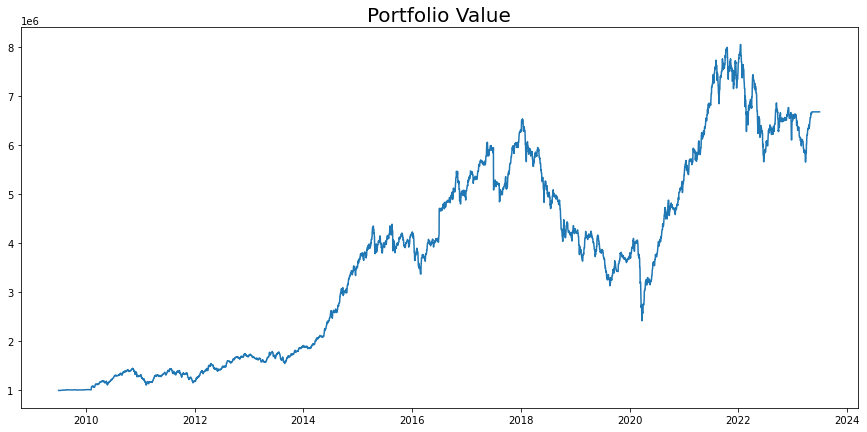

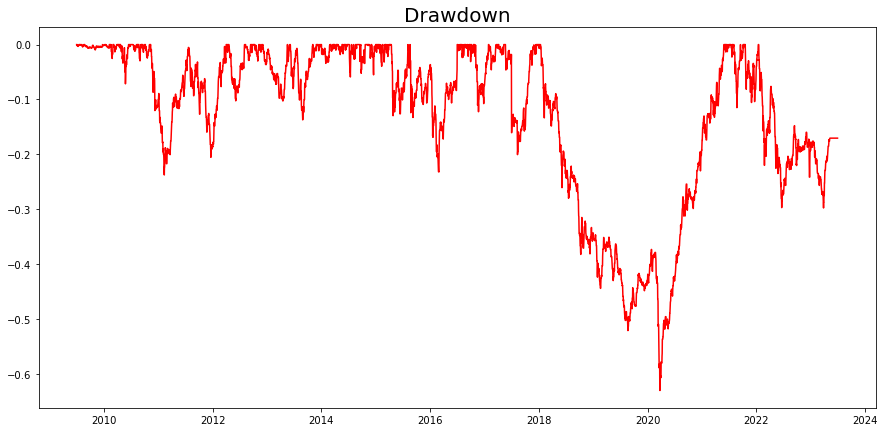

,CAGR,Trading Edge,MDD,CAR/MDD
0,14.527982,18.927817,-63.068406,0.230353


In [159]:
# TOP n Winners & Losers

winners = change[change['% Change']>0].sort_values(by="% Change", ascending=False)[['Name','Buy Date','% Change']]
losers  = change[change['% Change']<0].sort_values(by="% Change", ascending=True )[['Name','Buy Date','% Change']]
winners.reset_index(drop=True, inplace=True)
losers.reset_index(drop=True, inplace=True)

# Count of Winners & Losers
winners_counts = change[change['% Change']>0].shape[0] / change.shape[0]
losers_counts  = change[change['% Change']<0].shape[0] / change.shape[0]

# Average Win/Loss percentage
avg_win  = change[change['% Change']>0]['% Change'].mean()
avg_loss = change[change['% Change']<0]['% Change'].mean()


# Display Top 10 Winners & Losers
print("\nTOP WINNERS")
display(winners[:10])

print("\nTOP LOSERS")
display(losers[:10])



# Finding Daily Portfolio Value

k = 0

# Dataframe to append all year's Daily Portfolio Values
combined_PV = pd.DataFrame(columns=['Date','PV'])

for year in tqdm(range(start_year,end_year+1)):
    
    
    # Dataframe to add every stocks's Daily close price so as to get Daily Total Portfolio Value
    multipv = pd.DataFrame(columns=['Date','PV'])
    multipv['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
    multipv['PV'].fillna(0,inplace=True)
    
    
    
    #loop to go into each company from our trade sheet      //     i represents rows of the Trade Sheet.
    for i in range(k,(n-m)+k):
        
        # varibale to store close prices from start date to end date of a company
        pv1 = cdf[(cdf['Name']==change['Name'].iloc[i]) & (cdf['Date'] >= f'{year+1}{buy_str}') & (cdf['Date'] < f'{year+2}{sell_str}')]

        pv1 = pv1[['Name','Date','Close']]
        pv1.reset_index(drop=True, inplace = True)

        
        
        # filling all the missing dates in the above dataframe 
        all_dates = pd.DataFrame(columns=['Name','Date','Close'])
        all_dates['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
        
        for j in range(all_dates.shape[0]):
            if all_dates['Date'].iloc[j] not in pv1['Date'].tolist():
                pv1 = pd.concat((pv1,all_dates[j:j+1]),axis=0)
                #pv1 = pv1.append(all_dates.iloc[j])
        
        
        pv1.sort_values(by='Date', ascending=False, inplace=True) 
        pv1.reset_index(drop=True, inplace = True)
        
        
        # filling close prices as previous prices or next prices for newly added dates
        pv1 = pv1[['Name','Date','Close']].bfill().ffill()
        pv1.reset_index(drop=True, inplace = True)
        
        
        # Calculating Contract Value by Multiplying Close prices by Quantity of that company
        pv1['PV'] = pv1['Close']*change['Qty Holding'].iloc[i]
        pv1['Date'] = pd.to_datetime(pv1['Date'])

        # Adding the above company's Contarct Value to the previous company's Contract Value
        multipv['PV'] = np.where(multipv['Date'] == pv1['Date'], multipv['PV']+pv1['PV'], np.nan)
    
    
    # appending the above year's Daily Porfolio Value in a New Dataframe
    combined_PV = pd.concat((multipv,combined_PV),axis=0)
    #combined_PV = multipv.append(combined_PV)
    
    k += (n-m)


print("\nDaily Portfolio Value")
display(combined_PV)

print()



# Plotting Daily Portfolio Value
plt.figure(figsize=(15,7))
plt.plot(np.array(combined_PV["Date"]),np.array(combined_PV["PV"]))
plt.title("Portfolio Value", fontsize=20)
plt.show()

print()

# Plotting Daily Drawdown of our Portfolio
plt.figure(figsize=(15,7))
plt.plot(np.array(combined_PV["Date"]),np.array(combined_PV["MDD"]),color = 'red')
plt.title("Drawdown", fontsize=20)
plt.show()


# Ratios

tradingedge = winners_counts*avg_win + losers_counts*avg_loss

cagr = xirr([ str(buy_date) , str(sell_date) ],[-initial_capital,portfolio_value]) * 100

#cagr        = ((capital/initial_capital)**(1/(buy_date.year-start_year))-1)*100

mdd         = min(combined_PV['MDD'])*100

# Dataframe to store the above Ratios
calc = pd.DataFrame({"CAGR":[cagr],  "Trading Edge":[tradingedge], "MDD":[mdd], "CAR/MDD":[-cagr/mdd]})

display(calc)

___________

## Monthly Table
You'll get a matrix of Years and Months as output, which will have the monthly change of our Portfolio Value.

In [152]:
# Monthly Table

monthlydf = combined_PV.copy()

# Extracting Month & Year from the Date column
monthlydf['Date']  = pd.to_datetime(monthlydf['Date'])
monthlydf['Month'] = monthlydf['Date'].dt.month
monthlydf['Year']  = monthlydf['Date'].dt.year

# keeping only the last day of the month for each year
monthlydf = monthlydf.drop_duplicates(subset=['Month','Year'])[['Month','Year','PV']].reset_index(drop=True)
monthlydf['% Change'] = np.nan

# keeping only the last day of the year for each year
yearlydf = monthlydf.drop_duplicates(subset=['Year']).sort_values(by='Year',ascending=False).reset_index(drop=True)
yearlydf['% Change'] = np.nan

# Percentage change every month
for i in range(monthlydf.shape[0]):
    try:
        monthlydf['% Change'].iloc[i] = (monthlydf['PV'].iloc[i]/monthlydf['PV'].iloc[i+1] - 1)*100
    except:
        continue

        
# Percentage change every year
for i in range(yearlydf.shape[0]):
    try:
        y = monthlydf[monthlydf['Year']==yearlydf['Year'].iloc[i]]
        yearlydf['% Change'].iloc[i] = (y['PV'].iloc[0]/y['PV'].iloc[-1] - 1)*100
        
        #yearlydf['% Change'].iloc[i] = (yearlydf['PV'].iloc[i]/yearlydf['PV'].iloc[i+1] - 1)*100
        
    except:
        continue
        
        
# storing the unique years as a list
monthly_years = monthlydf['Year'].unique().tolist()
monthly_years = ['Months']+monthly_years

# New Dataframe to store our Monthly Table
monthly_matrix = pd.DataFrame(columns=monthly_years)
monthly_matrix['Months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']


for i in range(monthly_matrix.shape[0]):
    for j in monthlydf['Year'].unique().tolist():
        try:
            monthly_matrix[j].iloc[i] = monthlydf[(monthlydf['Month']==i+1) & (monthlydf['Year']==j)]['% Change'].iloc[0]
        except:
            continue
            
# The above Matrix has Months as rows & Years as columns
            
# Transposing the Matrix            
monthly_matrix = monthly_matrix.T
monthly_matrix.columns = monthly_matrix.iloc[0]
monthly_matrix.drop('Months', inplace=True)

monthly_matrix['Months']=monthly_matrix.index
monthly_matrix['Total'] = np.nan

# Adding yearly returns to the matrix
for i in range(monthly_matrix.shape[0]):
    monthly_matrix['Total'].iloc[i] = yearlydf[yearlydf['Year']==monthly_matrix['Months'].iloc[i]]['% Change'].iloc[0]

    
monthly_matrix.columns.name = ''
monthly_matrix.reset_index(drop=True, inplace=True)
monthly_matrix = monthly_matrix[['Months','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Total']]

# Adding Last row to store average returns of each month
monthly_matrix.loc['Average'] = monthly_matrix.mean()





display(monthly_matrix)




,Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Total
0,2023,-0.1663,-7.787472,-2.483571,12.378049,1.816647,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.888775
1,2022,-2.442752,-11.00541,1.393206,4.633296,-10.956949,-7.221735,8.610085,0.856839,0.311764,1.039184,2.731357,-2.450526,-13.217170
2,2021,1.711031,4.635236,2.353503,7.452639,5.516993,4.987711,10.018585,-3.12642,3.765728,-1.425362,-3.236598,5.760751,42.227909
3,2020,5.738317,-5.037685,-30.681851,26.613982,1.258188,11.479074,11.207602,8.654589,4.502888,-1.245358,8.573834,5.456159,34.328731
4,2019,-8.55226,-1.88287,8.173574,-3.081497,3.492308,-7.055669,-14.045248,-1.963101,7.857807,7.560467,-1.977812,0.864037,-4.362513
5,2018,-4.716426,-1.756587,-4.572211,4.893289,-11.49024,-3.727222,-2.095794,0.069472,-13.176555,-1.12007,-0.91653,1.744078,-28.947537
6,2017,6.958555,-0.931779,5.171892,-0.223848,3.534621,2.126884,-12.607504,-2.539764,1.703053,13.08989,3.740913,4.431275,16.661216
7,2016,-8.724877,-12.324026,10.59888,6.752172,1.116797,4.109656,14.720465,1.219896,1.760904,8.99993,-6.157707,0.025252,31.748170
8,2015,5.49286,0.238348,6.758752,-3.214895,7.058447,-4.650195,6.018268,-3.296819,-0.877278,2.408835,-1.56784,3.933929,12.567528
9,2014,-2.542924,3.457587,7.225211,1.373841,7.686615,11.217846,4.065036,6.658958,8.749102,7.958961,4.739836,3.71432,90.659535


---------

## Comparison with Indexes ⬇
Comparing the returns of our Portfolio with :
* *Nifty 50*
* *Nifty Midcap 100*
* *BSE500*

Nifty50
NiftyMidcap100
BSE500


,Date,Nifty50,NiftyMidcap100,BSE500,QGF
0,2023-05-15,18380.70,32584.35,24705.79,6.684090e+06
1,2023-05-14,18314.80,32468.45,24622.46,6.684090e+06
2,2023-05-13,18314.80,32468.45,24622.46,6.684090e+06
3,2023-05-12,18314.80,32468.45,24622.46,6.684090e+06
4,2023-05-11,18297.00,32601.30,24631.35,6.684090e+06
...,...,...,...,...,...
5062,2009-07-05,4424.25,5537.45,7000.55,9.938232e+05
5063,2009-07-04,4424.25,5537.45,7000.55,9.938232e+05
5064,2009-07-03,4424.25,5537.45,7000.55,9.938232e+05
5065,2009-07-02,4348.85,5496.00,7000.55,9.935287e+05


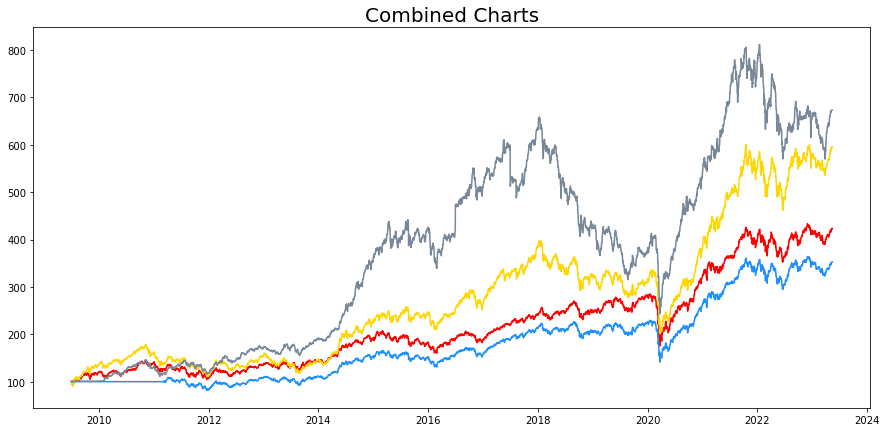

Nifty50        : RED 
NiftyMidcap100 : YELLOW 
BSE500         : BLUE 
QGF            : GREY


,Index,CAGR
0,Nifty50,323.430625
1,NiftyMidcap100,495.196865
2,BSE500,252.912128
3,QGF,573.182163


,Date,Nifty50,NiftyMidcap100,BSE500,QGF
0,2023-05-15,423.430625,595.196865,352.912128,673.182163
1,2023-05-14,421.912507,593.079797,351.721793,673.182163
2,2023-05-13,421.912507,593.079797,351.721793,673.182163
3,2023-05-12,421.912507,593.079797,351.721793,673.182163
4,2023-05-11,421.502453,595.506480,351.848783,673.182163
...,...,...,...,...,...
5062,2009-07-05,101.920109,101.148953,100.000000,100.092007
5063,2009-07-04,101.920109,101.148953,100.000000,100.092007
5064,2009-07-03,101.920109,101.148953,100.000000,100.092007
5065,2009-07-02,100.183142,100.391813,100.000000,100.062347


In [158]:
# Comparison with Indexes


indexes = ['Nifty50','NiftyMidcap100','BSE500']

comparisons = pd.DataFrame({'Index':['Nifty50', 'NiftyMidcap100', 'BSE500','QGF']})
comparisons['CAGR'] = np.nan

combined_ind = pd.DataFrame()
# combined_ind['Date'] = pd.date_range(date(start_year,buy_date.month,buy_date.day) ,date(buy_date.year,buy_date.month,buy_date.day)-datetime.timedelta(1)).sort_values(ascending=False)


for index in indexes:
    print(index)
    idf  = pd.read_excel(index_path, sheet_name=index)
    idf['Date'] = pd.to_datetime(idf['Date'])
    
    idf2 = idf[(idf['Date'] >= str(buy_date)) & (idf['Date'] <= str((sell_date-datetime.timedelta(1))))]
    idf2['Date'] = pd.to_datetime(idf2['Date'])
    #display(idf2)
    #date(buy_date.year,buy_date.month,buy_date.day)
    
    combined_ind['Date'] = idf2['Date']
    combined_ind[index] = idf2['Close']
    
    for i in range(comparisons.shape[0]):
        if comparisons['Index'].iloc[i] == index:
            comparisons['CAGR'].iloc[i] = ((idf2['Close'].iloc[0]/idf2[idf2['Close']!=0]['Close'].iloc[-1])**(1/(buy_date.year-start_year))-1)*100
            
        elif comparisons['Index'].iloc[i] == 'QGF':
            comparisons['CAGR'].iloc[i] = ((combined_PV['PV'].iloc[0]/combined_PV['PV'].iloc[-1])**(1/(buy_date.year-start_year))-1)*100
    
pv = combined_PV[(combined_PV['Date'] >= combined_ind['Date'].iloc[-1]) & (combined_PV['Date'] <= combined_ind['Date'].iloc[0])]
#display(pv)

pv.reset_index(drop=True,inplace=True)

combined_ind['QGF'] = pv['PV']

display(combined_ind)

for column in combined_ind.columns:
    if column == 'Date':
        continue
    else:
        combined_ind[column] = (combined_ind[column]  / combined_ind[column].iloc[-1])*100


plt.figure(figsize=(15,7))
plt.plot(np.array(combined_ind["Date"]),np.array(combined_ind["Nifty50"]), color = "red")
plt.plot(np.array(combined_ind["Date"]),np.array(combined_ind["NiftyMidcap100"]), color = "gold")
plt.plot(np.array(combined_ind["Date"]),np.array(combined_ind["BSE500"]),"dodgerblue")
plt.plot(np.array(combined_ind["Date"]), np.array(combined_ind['QGF']),color="lightslategrey")
plt.title("Combined Charts", fontsize=20)
plt.show()

print("Nifty50        : RED \nNiftyMidcap100 : YELLOW \nBSE500         : BLUE \nQGF            : GREY")
    
    
display(comparisons)

display(combined_ind)


---------

## Save the Output files
Run this Code to save all the Output Reports & files you get.

In [ ]:
with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
    TradeSheet.to_excel(writer,sheet_name="Tradesheet",index=False)
    combined_PV.to_excel(writer,sheet_name="Daily Portfolio Value",index=False)
    winners.to_excel(writer,sheet_name="Winners",index=False)
    losers.to_excel(writer,sheet_name="Losers",index=False)
    calc.to_excel(writer,sheet_name="Calculations",index=False)
    monthly_matrix.to_excel(writer,sheet_name="Monthly Table",index=False)
    combined_ind.to_excel(writer,sheet_name="Daily Index Prices",index=False)
    comparisons.to_excel(writer,sheet_name="Index Comparisons",index=False)

___________

## Output Variable names
* change : Tradelist
* combined_PV : Daily Portfolio Value
* winners : All Winners in descending
* losers : All Losers in ascending
* cagr : CAGR
* tradingedge : Trading Edge
* mdd : Max Drawdown
* monthly_matrix : Monthly Table
* comparisons : QGF vs Indexes change
* combined_ind : Daily Index Prices for given range

___________